### Now let us make some line plots to see what is happening for various tile applications:
- Want building density as one metric
- Want % building occupancy as another metric -> need to implement this one still.

In [1]:
import pandas as pd
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize 

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import sys
from skimage.color import rgb2gray
from tensorflow import keras

2022-10-20 10:34:37.389537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-20 10:34:37.547393: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-20 10:34:38.001397: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/shaun/miniconda3/envs/tf/lib/
2022-10-20 10:34:38.001495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin

In [2]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [3]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

NUM_TEST_IMAGES = 50

In [4]:
# get a list of files in each folder
base = r'/home/shaun/data/merged'
img_list = os.listdir(os.path.join(base, '2015_2016/tiles'))
mask_list = os.listdir(os.path.join(base, 'outlines/tiles'))

# create a dataframe
df_images = pd.DataFrame(img_list, columns=['image_id'])

# filter out the non image file that's called .htaccess
df_images = df_images[df_images['image_id'] != '.htaccess']

def check_for_mask(x):
    if x in mask_list:
        return 'yes'
    else:
        return 'no'
    
# create a new column called 'has_mask'
df_images['has_mask'] = df_images['image_id'].apply(check_for_mask)

df_masks = df_images[df_images['has_mask'] == 'yes']

# create a new column called mask_id that is just a copy of image_id
df_masks['mask_id'] = df_masks['image_id']

df_masks.shape

df_images.head(10)

,image_id,has_mask
0,2015_2016__91.jpg,yes
1,2015_2016__1146.jpg,yes
2,2015_2016__1618.jpg,yes
3,2015_2016__7087.jpg,yes
4,2015_2016__8256.jpg,yes
5,2015_2016__7144.jpg,yes
6,2015_2016__627.jpg,yes
7,2015_2016__5547.jpg,yes
8,2015_2016__4961.jpg,yes
9,2015_2016__4325.jpg,yes


In [5]:
# create a test set
df_test = df_masks.sample(NUM_TEST_IMAGES, random_state=102)

# Reset the index.
# This is so that we can use loc to access mask id's later.
df_test = df_test.reset_index(drop=True)

# create a list of test images
test_images_list = list(df_test['image_id'])

# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_masks = df_masks[~df_masks['image_id'].isin(test_images_list)]

print(df_masks.shape)
print(df_test.shape)

(7858, 3)
(50, 3)


In [6]:
# Get lists of images and their masks.
image_id_list = list(df_masks['image_id'])
mask_id_list = list(df_masks['mask_id'])
test_id_list = list(df_test['image_id'])

# Create empty arrays

X_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

Y_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

X_test = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

X_test.shape

(50, 224, 224, 3)

In [7]:
# X_test
selected = ['2015_2016__69.jpg', '2015_2016__73.jpg', '2015_2016__094.jpg',
            '2015_2016__79.jpg', '2015_2016__87.jpg', '2015_2016__097.jpg',
            '2015_2016__104.jpg', '2015_2016__158.jpg', '2015_2016__170.jpg',
            '2015_2016__180.jpg']

# dense_blds = ['rolleston_13824_13312.jpeg', 'rolleston_13824_13824.jpeg', 'rolleston_14336_10752.jpeg',
#               'rolleston_14336_11264.jpeg', 'rolleston_14336_11776.jpeg', 'rolleston_14336_25088.jpeg',
#               'rolleston_14848_10240.jpeg', 'rolleston_14848_11264.jpeg', 'rolleston_15360_1536.jpeg',
#               'rolleston_15360_6656.jpeg']

for i, image_id in enumerate(df_test['image_id']):
    
    path_image = os.path.join(base, '2015_2016/tiles', image_id)
    
    # read the image using skimage
    image = imread(path_image)
    
    # resize the image
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    # image = np.expand_dims(image, axis=-1)
    
    # insert the image into X_test
    X_test[i] = image
    
X_test.shape

(50, 224, 224, 3)

In [8]:
test_masks = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

for i, img in enumerate(df_test['image_id']):
    path_image = os.path.join(base, 'outlines/tiles', img)
    image = imread(path_image)
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    image = rgb2gray(image)
    image = np.expand_dims(image, axis=-1)
    test_masks[i] = image
test_masks.shape

(50, 224, 224, 3)

In [9]:
model = keras.models.load_model('/home/shaun/PHYS_391B/model.h5')

2022-10-20 10:34:40.183411: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 10:34:40.196033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 10:34:40.196698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 10:34:40.197369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
test_preds = model.predict(X_test)
test_preds.shape

2022-10-20 10:34:41.707986: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-10-20 10:34:42.270416: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/2 [==============>...............] - ETA: 2s

2022-10-20 10:34:43.462424: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2/2 [==============================] - 3s 369ms/step


(50, 224, 224, 1)

In [11]:
titles = ['Satellite image', 'Raw prediction', 'Outline via proposed method', 'Ground truth mask', 
          'Variable threshold', 'Outline + threshold', 'Static Threshold', 'openCV2 floodfill']

In [12]:
def calc_build_density(array):
    """Finds the area occupied by buildings, from image pixel size.

    Args:
        array (ndarray): expects a 2D numpy array, with strict pixel values of 0,255

    Returns:
        float: decimal percentage building density
    """
    # We want to raise an assertion error if any pixels in the inputted array aren't black or white.
    bool_test = np.isin(array, np.array([0, 255]))
    assert np.any(bool_test, where=False) == False
    
    build_pixels_mask = np.where(array == 255)
    build_pixels_mask_count = len(array[build_pixels_mask[0]][build_pixels_mask[1]])
    
    return build_pixels_mask_count / (array.shape[0] * array.shape[1])

In [13]:
def fillhole(input_image):
    '''
    input gray binary image  get the filled image by floodfill method
    Note: only holes surrounded in the connected regions will be filled.
    :param input_image:
    :return:
    '''
    im_flood_fill = input_image.copy()
    h, w = input_image.shape[:2]
    mask = np.zeros((h + 2, w + 2), np.uint8)
    im_flood_fill = im_flood_fill.astype("uint8")
    cv2.floodFill(im_flood_fill, mask, (0, 0), 255)
    im_flood_fill_inv = cv2.bitwise_not(im_flood_fill)
    img_out = input_image | im_flood_fill_inv
    return img_out 

In [14]:
# Define some globals here to keep things consistent.
TUNABLE_PARAM = 2
KERNEL_SIZE = 5
STATIC_THRESH = 0.31

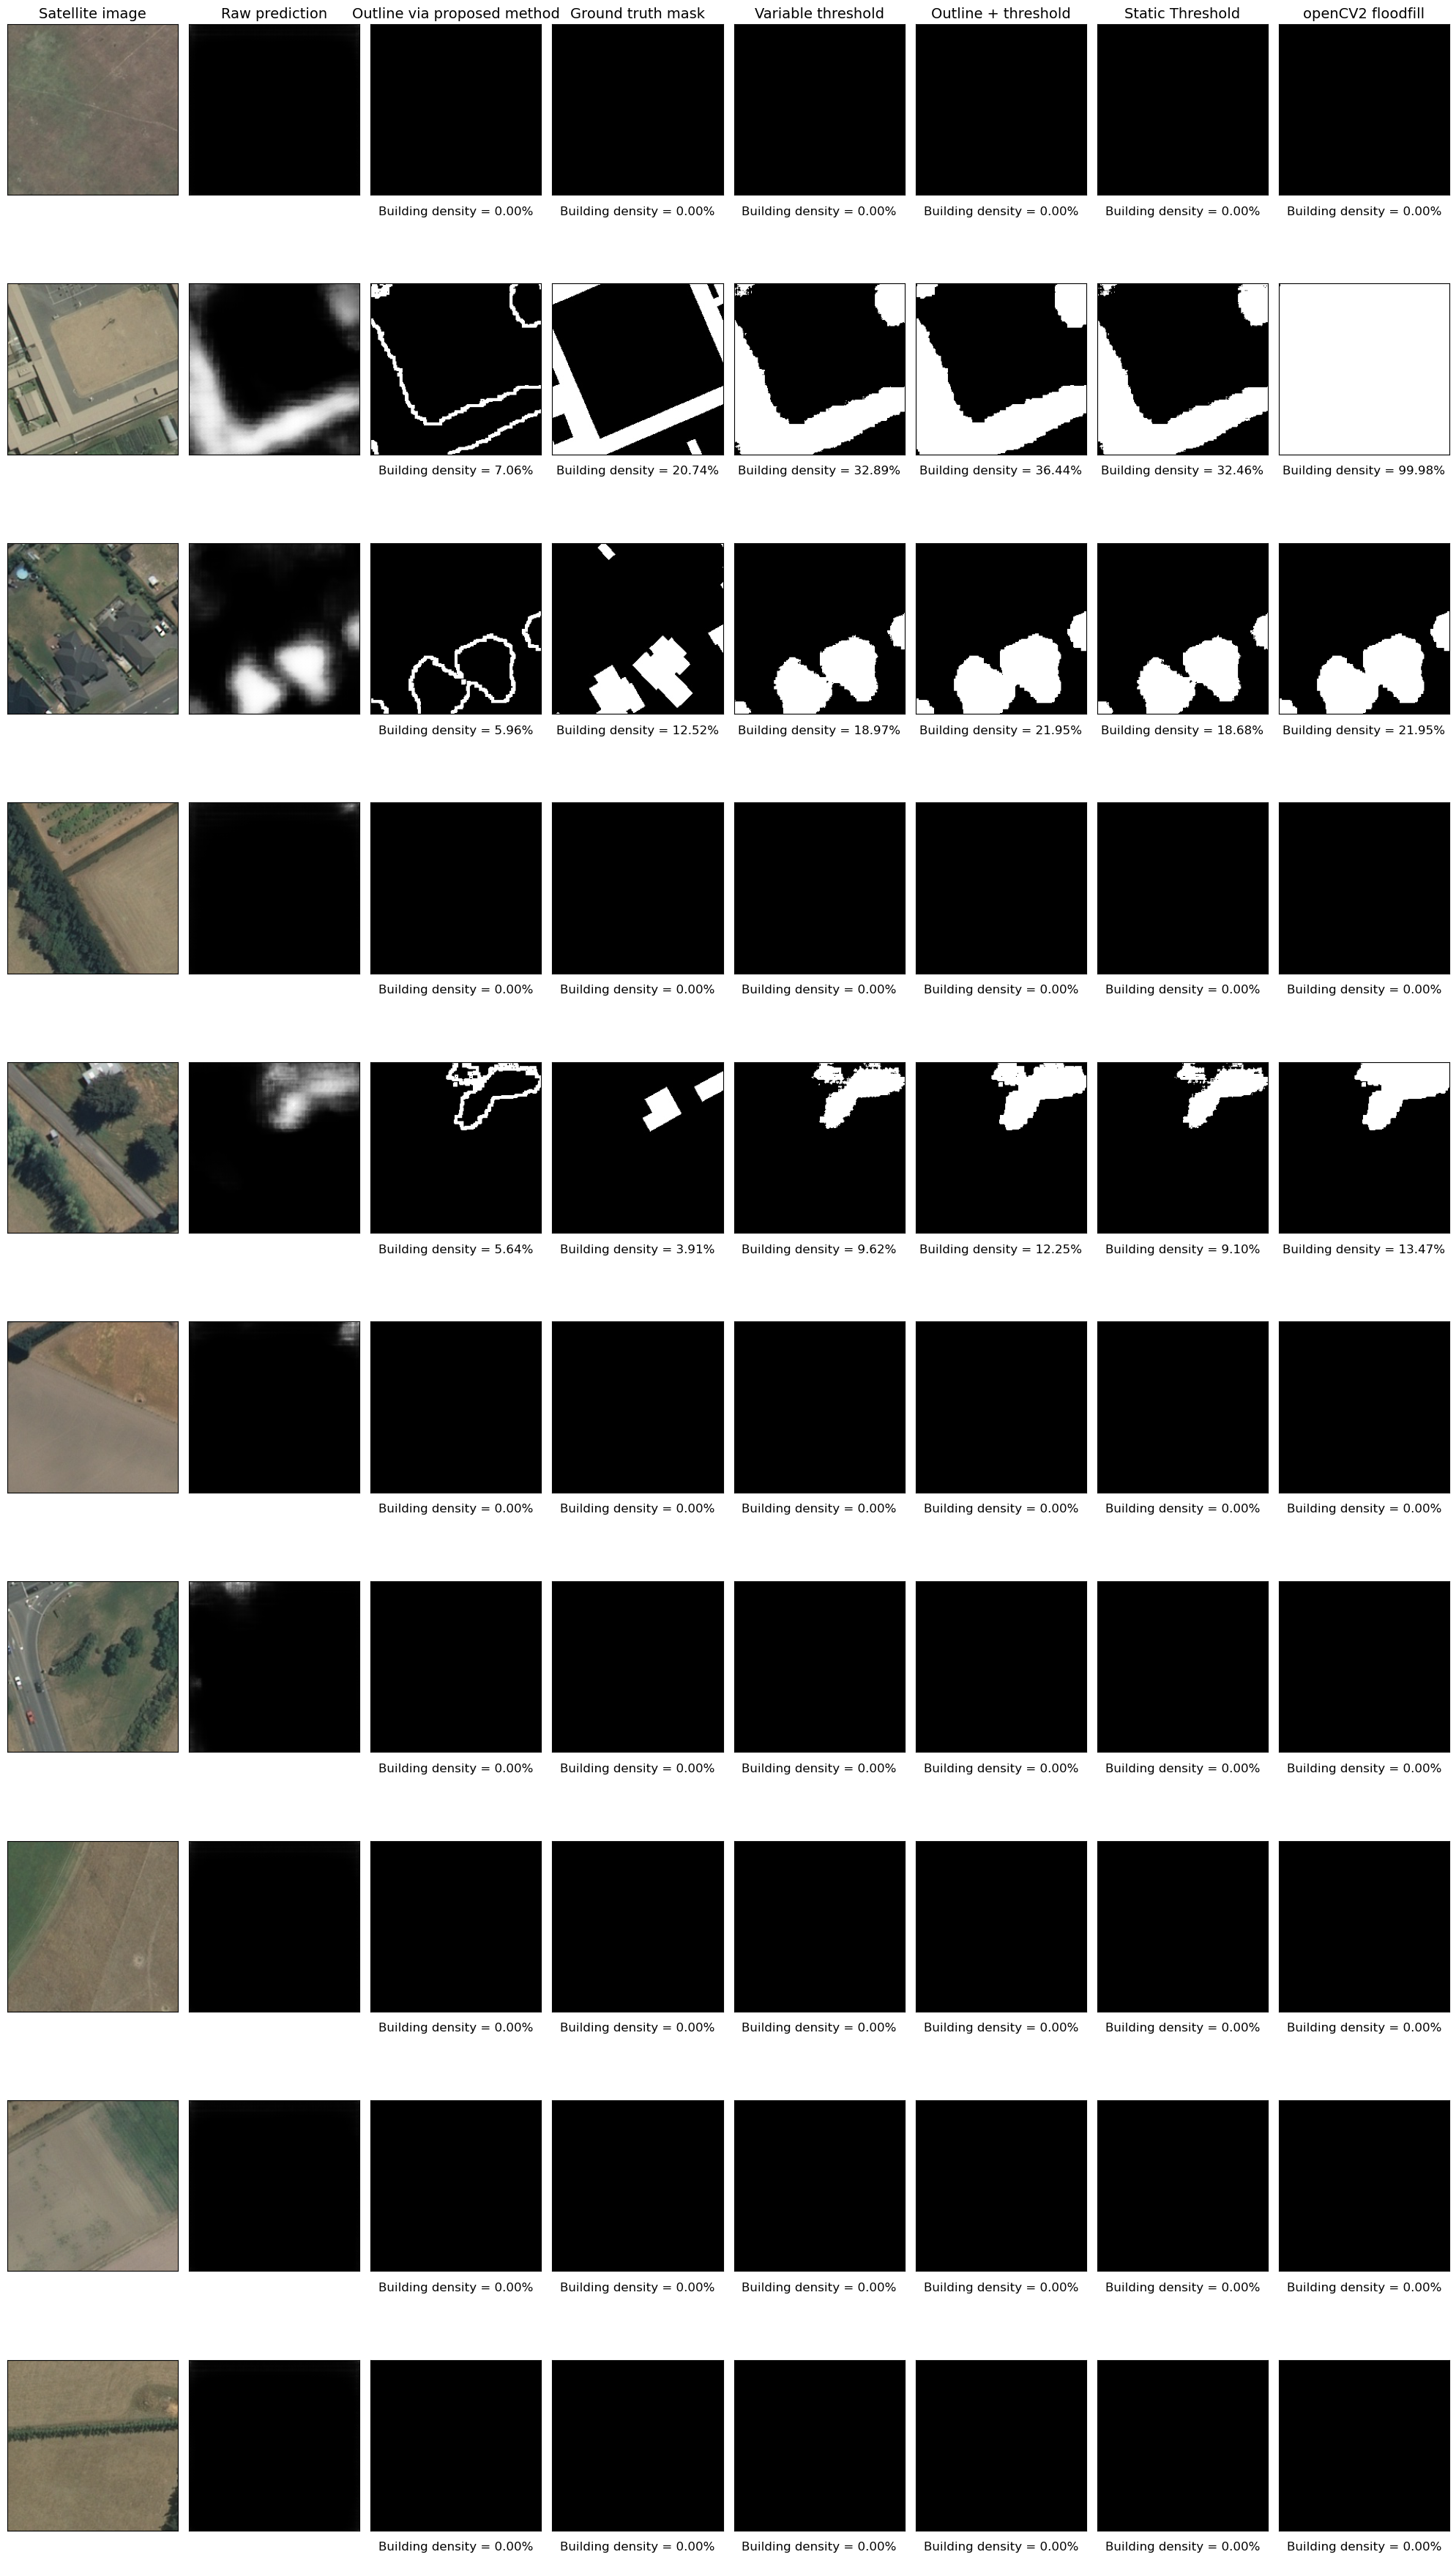

In [15]:
fig, ax = plt.subplots(10, 8, figsize=(20, 36))

for i in range(0, 10):

    test_img = test_preds[i, :, :, 0] #some random im
    specific_mask = test_masks[i, :, :, 0]
    specific_sat = X_test[i, :, :]

    # A raw threshold purely by inspection
    preds_test_thresh = (test_preds >= STATIC_THRESH).astype(np.uint8)
    raw_thresh = preds_test_thresh[i, :, :, 0]

    std = np.std(test_img)
    mean = np.mean(test_img)
    
    thresh_im = (test_img >= mean + (TUNABLE_PARAM*std)).astype(np.uint8) # applying the upper std thresh
    thresh_im = (test_img >= 0.3).astype(np.uint8)

    ddepth=cv2.CV_16S
    # plt.imshow(test_img, cmap='gray')

    grad_x = cv2.Sobel(thresh_im, ddepth, 1, 0, ksize=KERNEL_SIZE) # have to eval 2d array seperately, then combine to get dx and dy, this is dx
    grad_y = cv2.Sobel(thresh_im, ddepth, 0, 1, ksize=KERNEL_SIZE) # This is dy

    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)

    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    grad = (grad >= 0.3).astype(np.uint8)

    filled = fillhole(grad)

    # simply add the numpy arrays here:
    combined = thresh_im + grad # This is allowed since the matrices have the same shapes, which will always be true in this application.
    combined[combined!=0] =1 # However we do need to make the map boolean, since the thresholded probabilities are much lower than the gradient values, otherwise the rendering doesnt work.
    
    
    ax[i][0].imshow(specific_sat)
    ax[i][1].imshow(test_img, cmap='gray')
    ax[i][2].imshow(grad, cmap='gray')
    ax[i][3].imshow(specific_mask, cmap='gray')
    ax[i][4].imshow(thresh_im, cmap='gray')
    ax[i][5].imshow(combined, cmap='gray')
    ax[i][6].imshow(raw_thresh, cmap='gray')
    ax[i][7].imshow(filled, cmap='gray')

    if i == 0:
        for j in range(0,len(ax[0,:])):
            ax[i][j].set_title(titles[j], fontsize=14)
            ax[i][j].set(ylabel=None)
            #.tick_params(left=False)
            ax[i][j].set(yticklabels=[], xticklabels=[])
            ax[i][j].tick_params(left=False, bottom=False)

    else:
        for j in range(0,len(ax[0,:])):
            ax[i][j].set(ylabel=None)
            ax[i][j].set(yticklabels=[], xticklabels=[])
            ax[i][j].tick_params(left=False, bottom=False)


    # Let us also add the building density as percentages
    # We need to set any value that wasn't thresholded to 255, so that we can count it with our function from earlier.
    grad[grad!=0] = 255
    thresh_im[thresh_im!=0] = 255
    combined[combined!=0] = 255
    raw_thresh[raw_thresh!=0] = 255
    filled[filled!=0] = 255

    ax[i][2].set_xlabel(f'Building density = {calc_build_density(grad)*100:.2f}%', fontsize=12)
    ax[i][3].set_xlabel(f'Building density = {calc_build_density(specific_mask)*100:.2f}%', fontsize=12)
    ax[i][4].set_xlabel(f'Building density = {calc_build_density(thresh_im)*100:.2f}%', fontsize=12)
    ax[i][5].set_xlabel(f'Building density = {calc_build_density(combined)*100:.2f}%', fontsize=12)
    ax[i][6].set_xlabel(f'Building density = {calc_build_density(raw_thresh)*100:.2f}%', fontsize=12)
    ax[i][7].set_xlabel(f'Building density = {calc_build_density(filled)*100:.2f}%', fontsize=12)

plt.tight_layout()
plt.show()

In [16]:
tile_vals = []

for i in range(len(test_preds[:, 0, 0, 0])):
    templist = []
    test_img = test_preds[i, :, :, 0] #some random im
    specific_mask = test_masks[i, :, :, 0]
    specific_sat = X_test[i, :, :]

    # A raw threshold purely by inspection
    preds_test_thresh = (test_preds >= STATIC_THRESH).astype(np.uint8)
    raw_thresh = preds_test_thresh[i, :, :, 0]

    std = np.std(test_img)
    mean = np.mean(test_img)

    thresh_im = (test_img >= mean + (TUNABLE_PARAM*std)).astype(np.uint8) # applying the upper std thresh
    thresh_im = (test_img >= 0.3).astype(np.uint8)

    ddepth=cv2.CV_16S
    # plt.imshow(test_img, cmap='gray')

    grad_x = cv2.Sobel(thresh_im, ddepth, 1, 0, ksize=KERNEL_SIZE) # have to eval 2d array seperately, then combine to get dx and dy, this is dx
    grad_y = cv2.Sobel(thresh_im, ddepth, 0, 1, ksize=KERNEL_SIZE) # This is dy

    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)

    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

    # simply add the numpy arrays here:
    combined = thresh_im + grad # This is allowed since the matrices have the same shapes, which will always be true in this application.
    combined[combined!=0] =1 
    # However we do need to make the map boolean, since the thresholded probabilities 
    # are much lower than the gradient values, otherwise the rendering doesnt work.


    # Let us also add the building density as percentages
    # We need to set any value that wasn't thresholded to 255, so that we can count it with our function from earlier.
    grad[grad!=0] = 255
    thresh_im[thresh_im!=0] = 255
    combined[combined!=0] = 255
    raw_thresh[raw_thresh!=0] = 255
    specific_mask[specific_mask!=0] = 255

    templist.append(calc_build_density(grad)*100)
    templist.append(calc_build_density(specific_mask)*100)
    templist.append(calc_build_density(thresh_im)*100)
    templist.append(calc_build_density(combined)*100)
    templist.append(calc_build_density(raw_thresh)*100)

    tile_vals.append(templist)


In [17]:
density_outlines = np.array(tile_vals)

In [18]:
density_outlines.shape

(50, 5)

In [19]:
titles[2:-1]

['Outline via proposed method',
 'Ground truth mask',
 'Variable threshold',
 'Outline + threshold',
 'Static Threshold']

In [20]:
densities_df = pd.DataFrame(data=density_outlines, columns=titles[2:-1])
# densities_df.to_csv(r'/home/shaun/PHYS_391B/densities.csv', index=True)

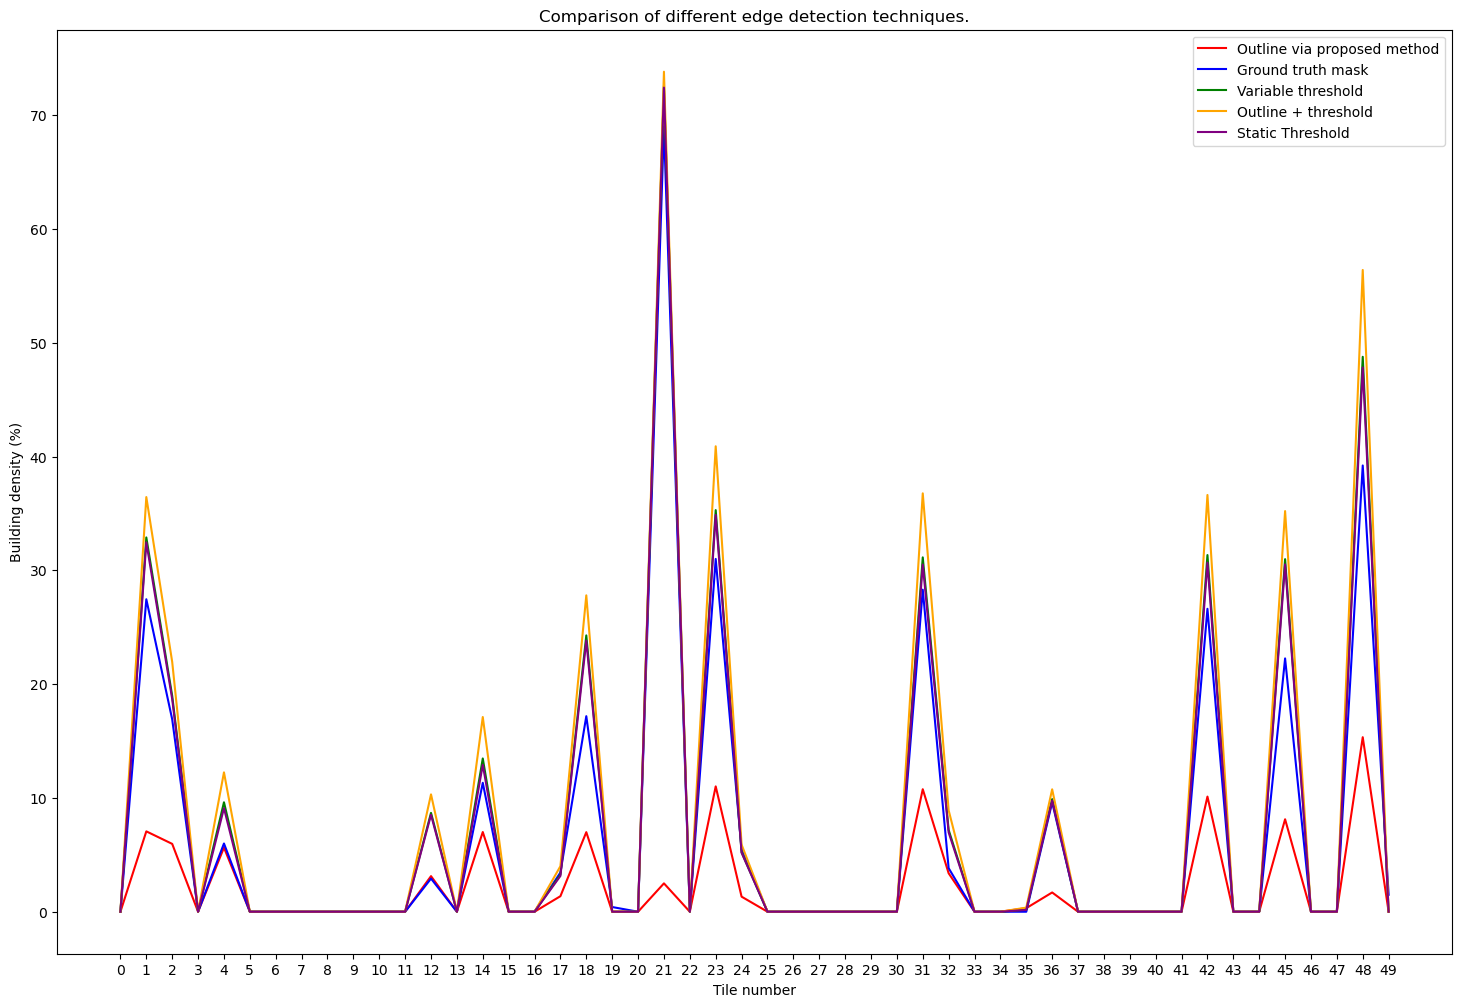

In [21]:
fig, ax = plt.subplots(figsize=(18, 12))
colours = ['red', 'blue', 'green', 'orange', 'purple']
for i in range(0, density_outlines.shape[1]):
    x = np.arange(0, density_outlines.shape[0], 1)
    y = density_outlines[:, i]
    ax.plot(x, y, color=colours[i], label=titles[i+2])

ax.legend(loc = 'upper right')
ax.set_xticks(np.arange(0, density_outlines.shape[0], 1))
plt.title('Comparison of different edge detection techniques.')
ax.set_xlabel('Tile number')
ax.set_ylabel('Building density (%)')
plt.show()

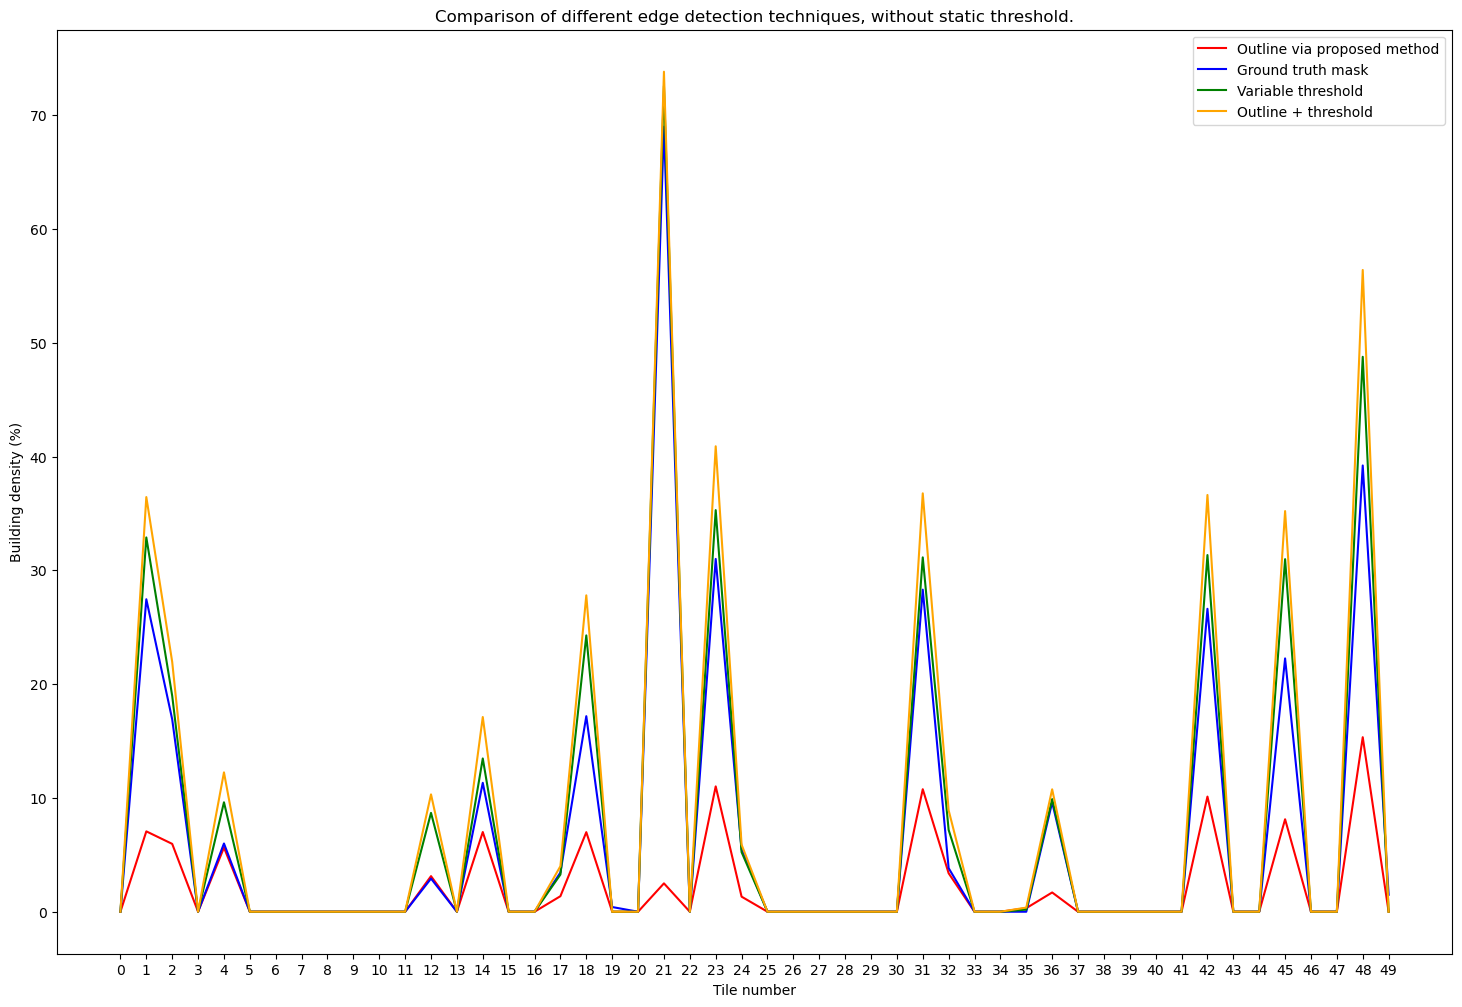

In [22]:
fig, ax = plt.subplots(figsize=(18, 12))
colours = ['red', 'blue', 'green', 'orange', 'purple']
for i in range(0, density_outlines.shape[1]-1):
    x = np.arange(0, density_outlines.shape[0], 1)
    y = density_outlines[:, i]
    ax.plot(x, y, color=colours[i], label=titles[i+2])

ax.legend(loc = 'upper right')
ax.set_xticks(np.arange(0, density_outlines.shape[0], 1))
plt.title('Comparison of different edge detection techniques, without static threshold.')
ax.set_xlabel('Tile number')
ax.set_ylabel('Building density (%)')
plt.show()
plt.show()

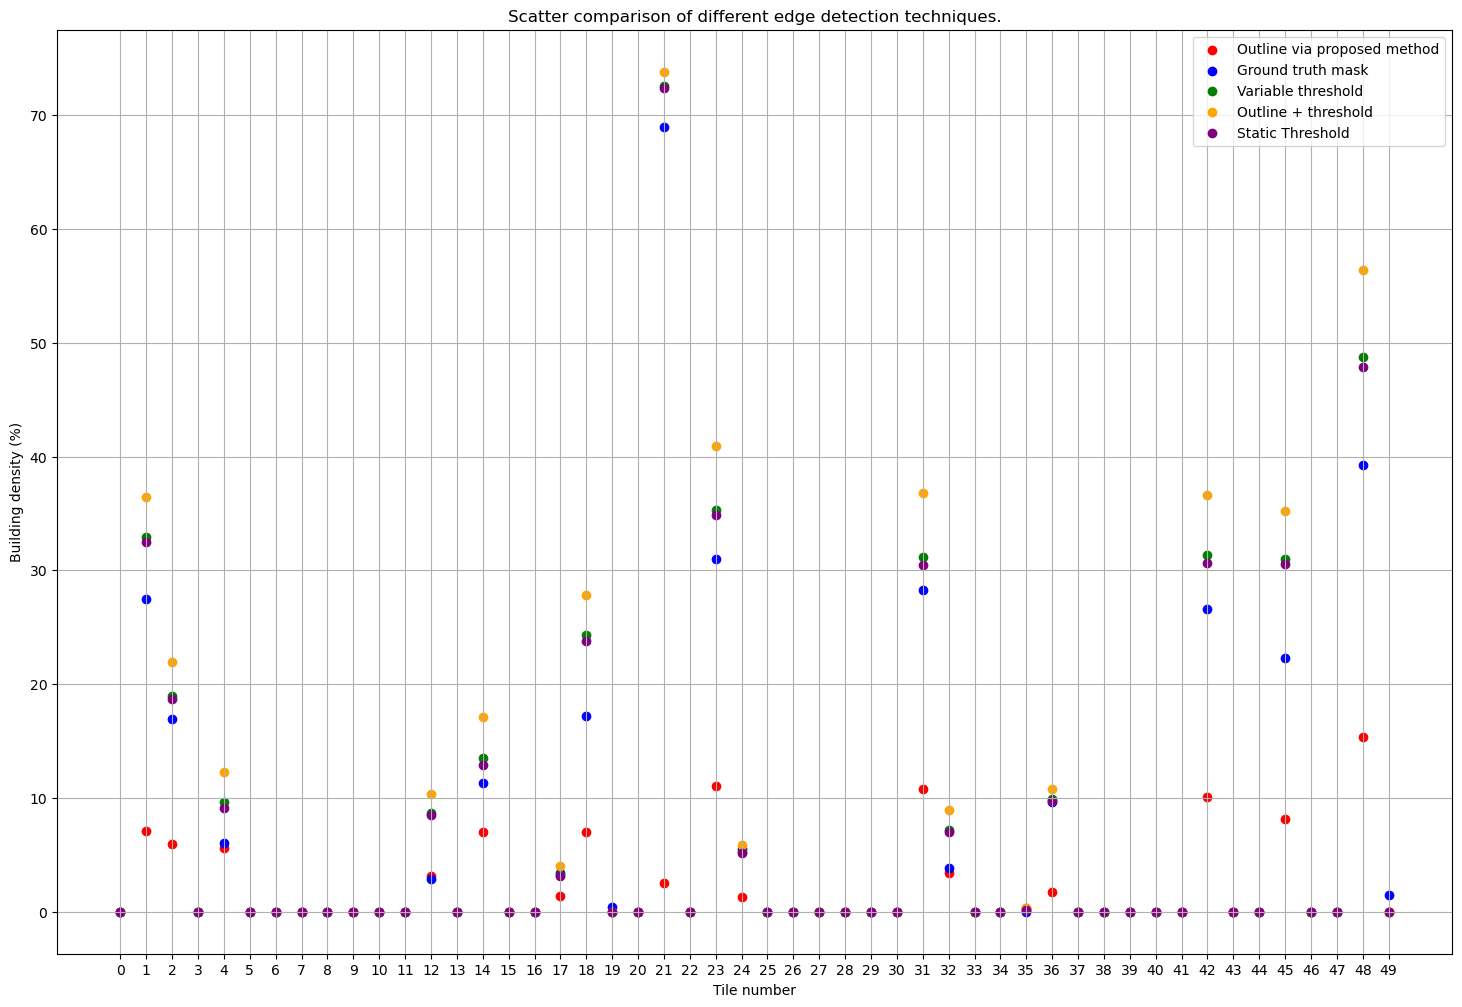

In [23]:
fig, ax = plt.subplots(figsize=(18, 12))
colours = ['red', 'blue', 'green', 'orange', 'purple']
for i in range(0, density_outlines.shape[1]):
    x = np.arange(0, density_outlines.shape[0], 1)
    y = density_outlines[:, i]
    ax.scatter(x, y, color=colours[i], label=titles[i+2])

ax.legend(loc = 'upper right')
ax.set_xticks(np.arange(0, density_outlines.shape[0], 1))
plt.grid(alpha=1)
plt.title('Scatter comparison of different edge detection techniques.')
ax.set_xlabel('Tile number')
ax.set_ylabel('Building density (%)')
plt.show()
plt.show()

In [24]:
density_outlines.shape

(50, 5)

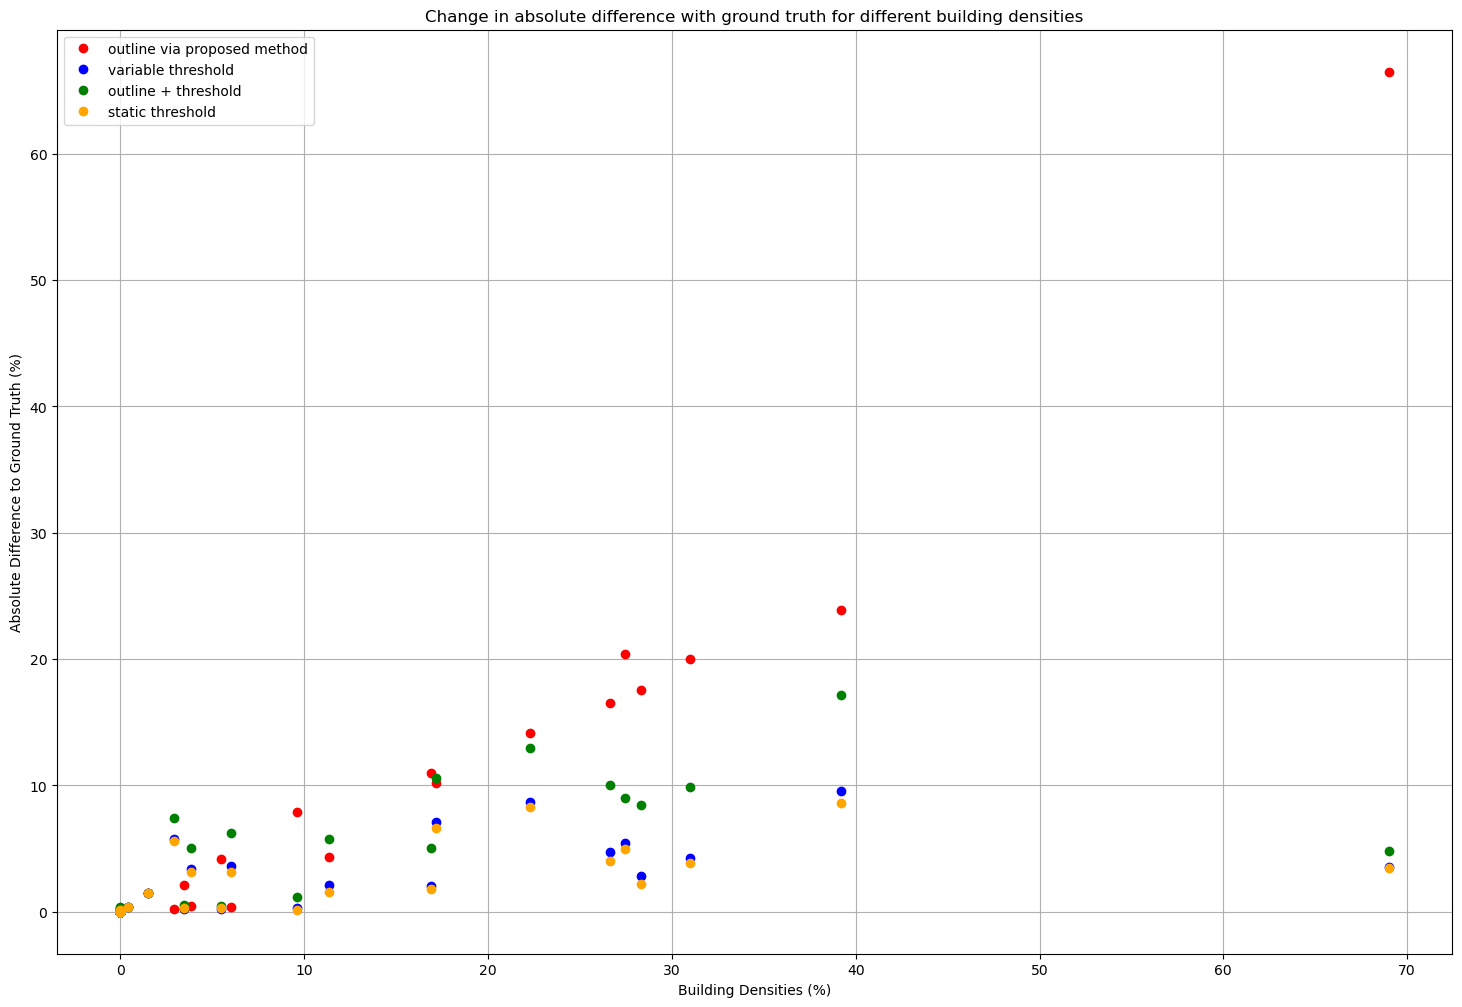

In [25]:
gnd_truth = density_outlines[:,1]

outline_via_proposed_method = np.abs(density_outlines[:,0] - gnd_truth)
variable_threshold = np.abs(density_outlines[:,2] - gnd_truth)
outline_threshold = np.abs(density_outlines[:,3] - gnd_truth)
static_threshold = np.abs(density_outlines[:,4] - gnd_truth)


plt.figure(figsize=(18, 12))
plt.plot(gnd_truth, outline_via_proposed_method, 'o', label='outline via proposed method', color='red')
plt.plot(gnd_truth, variable_threshold, 'o', label='variable threshold', color='blue')
plt.plot(gnd_truth, outline_threshold, 'o', label='outline + threshold', color='green')
plt.plot(gnd_truth, static_threshold, 'o', label='static threshold', color='orange')
plt.xlabel('Building Densities (%)')
plt.ylabel('Absolute Difference to Ground Truth (%)')
plt.title('Change in absolute difference with ground truth for different building densities')
plt.grid()
plt.legend()
plt.show(block=False)

In [26]:
variable_threshold.mean(), static_threshold.mean()

(1.3190768494897958, 1.2013711734693875)

In [27]:
variable_threshold.mean() - static_threshold.mean()

0.11770567602040827

In [28]:
len(test_preds[:, 0, 0, 0])

50

### Building occupation metric

### $\textbf{coverage} = \frac{\textbf{sum}(\textbf{ground truth array} \times \textbf{threshold array})}{\textbf{\textbf{total ground truth pixels}}} \times 100$

In [29]:
def find_overlap(ground_truth, array):
    """Find how much per pixel overlap the inputted array has with the ground truth array.

    Args:
        ground_truth (ndarray): The mask or ground truth array, should be 0,255. 
        array (ndarray): The array to be tested for finding overlap value.
    """
    truth_count = (ground_truth != 0).sum()
    overlap = (ground_truth * array != 0).sum()
    if truth_count == 0:
        return overlap + 100
    else:
        return overlap / truth_count *100

In [30]:
overlaps = []

for i in range(len(test_preds[:, 0, 0, 0])):
    templist = []
    test_img = test_preds[i, :, :, 0] #some random im
    specific_mask = test_masks[i, :, :, 0]
    specific_sat = X_test[i, :, :]

    # A raw threshold purely by inspection
    preds_test_thresh = (test_preds >= STATIC_THRESH).astype(np.uint8)
    raw_thresh = preds_test_thresh[i, :, :, 0]

    std = np.std(test_img)
    mean = np.mean(test_img)

    thresh_im = (test_img >= mean + (TUNABLE_PARAM*std)).astype(np.uint8) # applying the upper std thresh
    thresh_im = (test_img >= 0.3).astype(np.uint8)

    ddepth=cv2.CV_16S
    # plt.imshow(test_img, cmap='gray')

    grad_x = cv2.Sobel(thresh_im, ddepth, 1, 0, ksize=KERNEL_SIZE) # have to eval 2d array seperately, then combine to get dx and dy, this is dx
    grad_y = cv2.Sobel(thresh_im, ddepth, 0, 1, ksize=KERNEL_SIZE) # This is dy

    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)

    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

    # simply add the numpy arrays here:
    combined = thresh_im + grad # This is allowed since the matrices have the same shapes, which will always be true in this application.
    combined[combined!=0] =1 
    # However we do need to make the map boolean, since the thresholded probabilities 
    # are much lower than the gradient values, otherwise the rendering doesnt work.


    # Let us also add the building density as percentages
    # We need to set any value that wasn't thresholded to 255, so that we can count it with our function from earlier.
    grad[grad!=0] = 255
    thresh_im[thresh_im!=0] = 255
    combined[combined!=0] = 255
    raw_thresh[raw_thresh!=0] = 255
    specific_mask[specific_mask!=0] = 255

    templist.append(find_overlap(specific_mask, grad))
    # templist.append(find_overlap(specific_mask))
    templist.append(find_overlap(specific_mask, thresh_im))
    templist.append(find_overlap(specific_mask, combined))
    templist.append(find_overlap(specific_mask, raw_thresh))

    overlaps.append(templist)

In [31]:
overlap_arr = np.array(overlaps)

In [32]:
overlap_titles = ['Outline via proposed method', 'Variable threshold', 'Outline + threshold', 'Static Threshold']

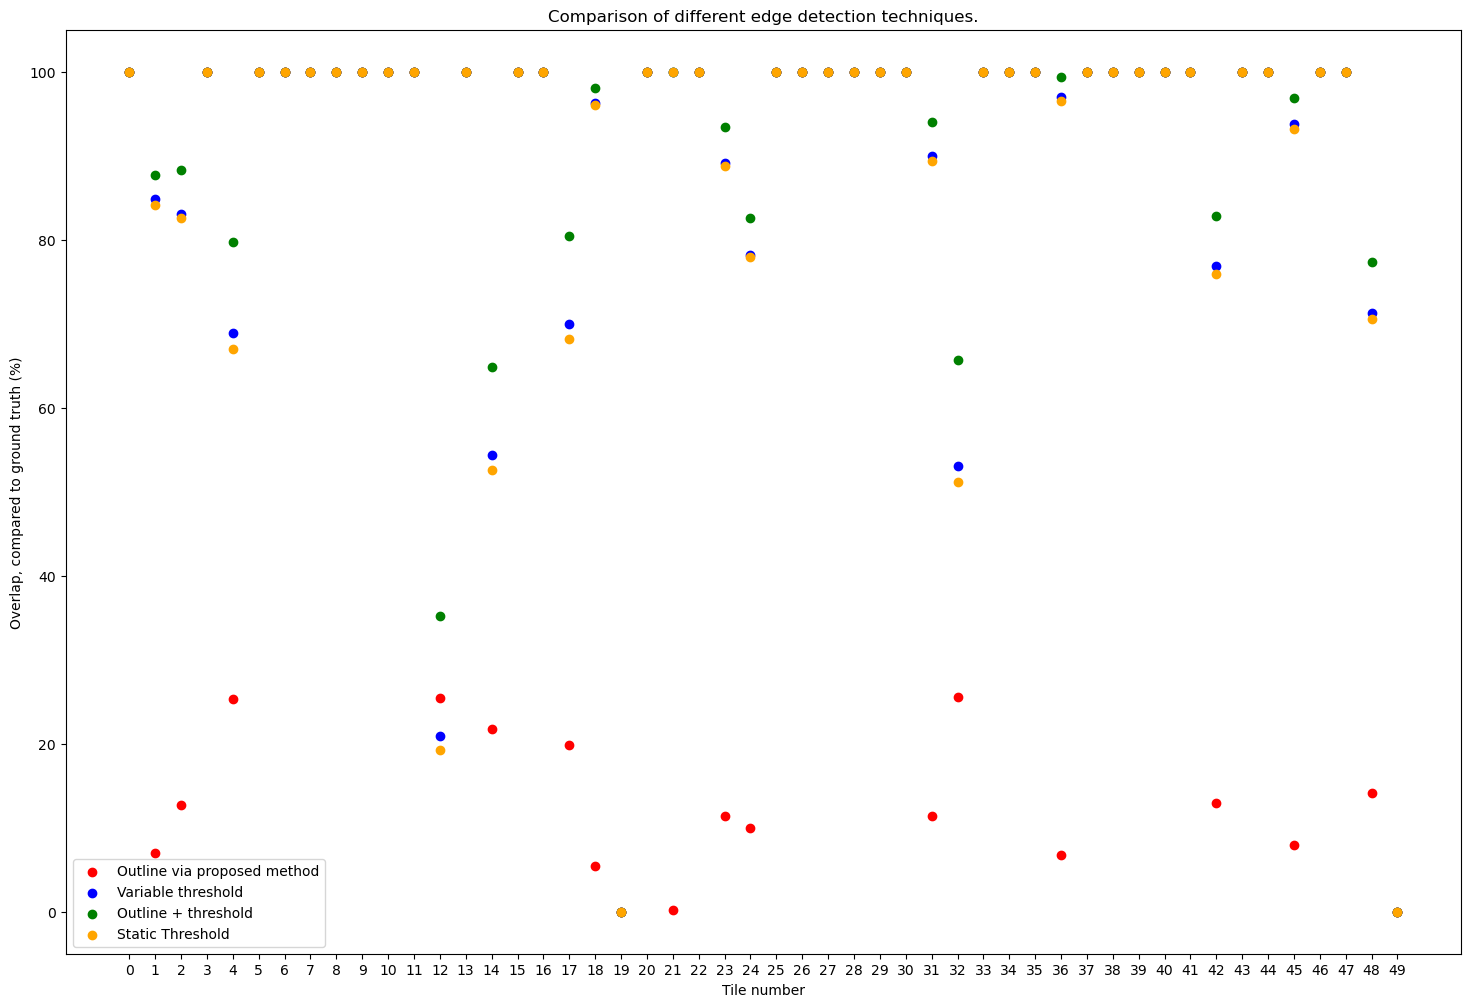

In [33]:
fig, ax = plt.subplots(figsize=(18, 12))
colours = ['red', 'blue', 'green', 'orange', 'purple']
for i in range(0, overlap_arr.shape[1]):
    x = np.arange(0, overlap_arr.shape[0], 1)
    y = overlap_arr[:, i]
    ax.scatter(x, y, color=colours[i], label=overlap_titles[i])

ax.legend()
ax.set_xticks(np.arange(0, overlap_arr.shape[0], 1))
plt.title('Comparison of different edge detection techniques.')
ax.set_xlabel('Tile number')
ax.set_ylabel('Overlap, compared to ground truth (%)')
plt.show()

In [34]:
overlap_arr.shape

(50, 4)

In [35]:
overlap_arr[:, 1].mean()

88.5545081321386

In [36]:
overlap_arr[:, -1].mean()

88.26207831133814

In [37]:
overlap_arr[:, 1].mean() - overlap_arr[:, -1].mean()

0.2924298208004501